In [1]:
import numpy as np
from numpy.linalg import multi_dot,inv,pinv,norm,eig
import scipy
from scipy.linalg import null_space
import pandas as pd
import cvxpy as cp
import pv_solver as pv

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
Sbase = 15000;
Vbase = 208;
Zbase = Vbase*Vbase/Sbase;
S_rated = 15000;
V_nom = 120; 
C = 0.2679*Zbase;
xi = 15*Vbase*Vbase;
Kappa_v = V_nom;
Kappa_i = 3*V_nom/S_rated;

Df = 3*C/Kappa_i/Kappa_v
Dv = 12*C*xi/Kappa_i/Kappa_v**3

R_eq_f = 1/5/Df/2/np.pi
R_eq_v = 1/5/Dv
R_eq_f, R_eq_v

(0.039546971951112696, 0.001378407654068091)

(19918.084130022486, 237.6370826856825)
9803.506587992357
19700.69910160541


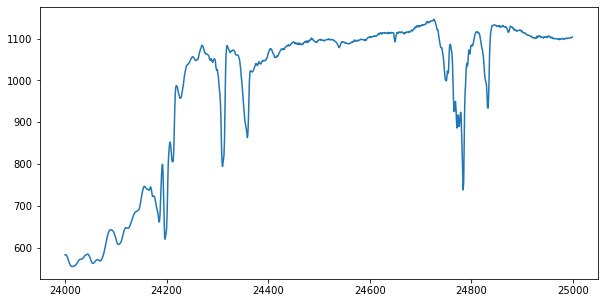

In [29]:
G = pd.read_csv("20111001_data.csv", header = 0)
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(G["s6"].iloc[24000:25000])
G6 = G["s6"].iloc[24200:25200].to_numpy().reshape(-1)

PV = pv.pv_panel(10,10)
print(PV.find_opt(1200,30+273))
print(PV.solve_i(1200,30+273,10,100)[0]*100)
print(PV.solve_i(1200,30+273,10,250)[0]*250)

P6max = []
for k in range(G6.shape[0]): 
    P6max.append([k+0.01,PV.find_opt(G6[k],30+273)[0]/Sbase])
np.savetxt("Input/P6max.csv", P6max, delimiter=",") 


In [ ]:
Xf,Xt,Xv,Yf,Yt,Yv,Yf_pred,Yt_pred,Yv_pred,err = [],[],[],[],[],[],[],[],[],[]
Lambda = [1] 
Wf,Wt,Wv = R_eq_f*np.r_[np.ones((5,1)),np.zeros((5,1))],np.zeros((10,1)),R_eq_v*np.r_[np.zeros((5,3)),np.ones((5,3))]
Pf,Pt,Pv = 1000*np.identity(Wf.shape[0]),1000*np.identity(Wt.shape[0]),1000*np.identity(Wv.shape[0])
P49_ref = 0.353
#### Estimate Sensitivities
def sensitivity(start):
    lmbda = 0.85
    
    dVolt = [x-y for x,y in zip(Voltages.iloc[-1].tolist()[1:],Voltages.iloc[-10].tolist()[1:])]
    dFreq = [sum(Frequencies.iloc[-1].tolist()[1:])/5.0-sum(Frequencies.iloc[-10].tolist()[1:])/5.0]
    dP49 = [Active_power.iloc[-1].tolist()[-1]-Active_power.iloc[-10].tolist()[-1]]
    Yf.append(dFreq)
    Yt.append(dP49)
    Yv.append(dVolt)
    
    Xf.append([P1_array[-1][1],P2_array[-1][1],P3_array[-1][1],P6_array[-1][1],P8_array[-1][1]])
    Xf[-1].extend([Q1_array[-1][1],Q2_array[-1][1],Q3_array[-1][1],Q6_array[-1][1],Q8_array[-1][1]])
    Xt.append([P1_array[-1][1],P2_array[-1][1],P3_array[-1][1],P6_array[-1][1],P8_array[-1][1]])
    Xt[-1].extend([Q1_array[-1][1],Q2_array[-1][1],Q3_array[-1][1],Q6_array[-1][1],Q8_array[-1][1]])    
    Xv.append([P1_array[-1][1],P2_array[-1][1],P3_array[-1][1],P6_array[-1][1],P8_array[-1][1]])
    Xv[-1].extend([Q1_array[-1][1],Q2_array[-1][1],Q3_array[-1][1],Q6_array[-1][1],Q8_array[-1][1]])
            
    Yf_pred.append(list(np.dot(np.array(Xf[-1]),Wf)))
    Yt_pred.append(list(np.dot(np.array(Xt[-1]),Wt)))
    Yv_pred.append(list(np.dot(np.array(Xv[-1]),Wv)))
    # Least Squares
#     X,Y = np.array(Xf),np.array(Yf)
#     L = Lambda[::-1]
#     Sf = multi_dot([np.linalg.pinv(np.dot(X.T*np.array(L),X)),X.T*np.array(L),Y])
#     X,Y = np.array(Xt),np.array(Yt)
#     St = multi_dot([np.linalg.pinv(np.dot(X.T*np.array(L),X)),X.T*np.array(L),Y])
#     X,Y = np.array(Xv),np.array(Yv)
#     Sv = multi_dot([np.linalg.pinv(np.dot(X.T*np.array(L),X)),X.T*np.array(L),Y])
#     Lambda.append(Lambda[-1]*lmbda)
    # Recursive Least Squares  
    X,Y = np.array(Xf),np.array(Yf)
    m = lmbda+multi_dot([X[-1].T,Pf,X[-1]])
    Pf_new = Pf/lmbda - multi_dot([Pf,np.reshape(X[-1],(-1, 1)),np.reshape(X[-1],(1, -1)),Pf])/m/lmbda       
    for i in range(Y.shape[1]):        
        Wf[:,i] = Wf[:,i] + np.dot(Pf_new,X[-1])*(Y[-1]-np.dot(X[-1],Wf[:,i]))
        
    X,Y = np.array(Xt),np.array(Yt)
    m = lmbda+multi_dot([X[-1].T,Pt,X[-1]])
    Pt_new = Pt/lmbda - multi_dot([Pt,np.reshape(X[-1],(-1, 1)),np.reshape(X[-1],(1, -1)),Pt])/m/lmbda       
    for i in range(Y.shape[1]):        
        Wt[:,i] = Wt[:,i] + np.dot(Pt_new,X[-1])*(Y[-1]-np.dot(X[-1],Wt[:,i]))
        
    X,Y = np.array(Xv),np.array(Yv)
    m = lmbda+multi_dot([X[-1].T,Pv,X[-1]])
    Pv_new = Pv/lmbda - multi_dot([Pv,np.reshape(X[-1],(-1, 1)),np.reshape(X[-1],(1, -1)),Pv])/m/lmbda       
    for i in range(Y.shape[1]):        
        Wv[:,i] = Wv[:,i] + np.dot(Pv_new,X[-1])*(Y[-1,i]-np.dot(X[-1],Wv[:,i]))
    
    err.append([100*abs(x-y)/max(abs(x),1e-4) for x,y in zip(Yf[-1],Yf_pred[-1])]+\
               [100*abs(x-y)/max(abs(x),1e-4) for x,y in zip(Yt[-1],Yt_pred[-1])]+\
               [100*abs(x-y)/max(abs(x),1e-4) for x,y in zip(Yv[-1],Yv_pred[-1])])
    print(f"error is {err[-1]}")
    
    for i in range(Pf_new.shape[1]):
        Pf[:,i] = Pf_new[:,i]
    for i in range(Pt_new.shape[1]):
        Pt[:,i] = Pt_new[:,i]
    for i in range(Pv_new.shape[1]):
        Pv[:,i] = Pv_new[:,i]
    
#### Solve optimization to compute secondary control input adjustment
def control_perturb(k): ### k - time instant
    np.random.seed(k)
    ave_freq = sum(Frequencies.iloc[-1].tolist()[1:])/5.0
    P49 = Active_power.iloc[-1].tolist()[-1]
    ave_volt = sum(Voltages.iloc[-1].tolist()[1:])/3.0
#     y = np.array([np.clip(60-ave_freq,-0.02,0.02)]+[np.clip(P49_ref-P49,-0.02,0.02)]+\
#                  [np.clip(1-Voltages.iloc[-1].tolist()[1],-0.03,0.03)]+\
#                  [np.clip(0.92-Voltages.iloc[-1].tolist()[2],-0.03,0.03)]+\
#                  [np.clip(0.93-Voltages.iloc[-1].tolist()[3],-0.03,0.03)])
    y = np.array([60-ave_freq]+[P49_ref-P49]+[1-Voltages.iloc[-1].tolist()[1]]+\
                 [0.92-Voltages.iloc[-1].tolist()[2]]+[0.93-Voltages.iloc[-1].tolist()[3]])
#     if k%4==2: y = y - y*np.random.uniform(0,0.5,size=(5,))
    A = np.r_[Wf.T,Wt.T,Wv.T]
    I = np.identity(10)
#     Diag = np.diag([5,1,1,1,1])
    rho = 5e-4
#     if k<80: ### initialization period till 80 sec
#         u = [np.clip((60-ave_freq),-0.05,0.05)]*5+[np.clip(5*(1-ave_volt),-0.2,0.2)]*5
#         a = [0.25,0.5,0.75,1]    
#         d = [a[i] for i in np.random.randint(4,size=(10,))]
#         return [x*y for x,y in zip(u,d)] 
#     else:     ### solve optimization   
    P = A.T @ A
    q = -2*A.T@y
    G = np.r_[I,-I]
    h = np.ones(20)*0.1-np.random.uniform(0,0.04,size=(20,))
    x = cp.Variable(10)
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, P) + q.T @ x),[G @ x <= h])
    prob.solve()
#         u = multi_dot([pinv(multi_dot([A.T,Diag,A])+rho*I),A.T,Diag,y])
    i = np.random.randint(0,null_space(A).shape[1])
#     if k%4==2: return [x+np.random.uniform(0,0.05)*d for x,d in zip(list(x.value),null_space(A)[:,i])]
    if k%4==2: return [x+0.03*d for x,d in zip(list(x.value),null_space(A)[:,i])]
    else: return list(x.value)

In [ ]:
W = np.r_[Wf.T,Wt.T,Wv.T]
print(W.shape)
print(null_space(W))
print(np.random.randint(0,W.shape[1]))

In [ ]:
import xmlrpc.client
server = xmlrpc.client.ServerProxy("http://localhost:1080/RPC2")
server.plecs.load("IEEE14_v10.plecs")
import time

folder = "Input/"
np.savetxt(folder+"P1.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P2.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P3.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P6.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"P8.csv", np.zeros((1,2)), delimiter=",")

np.savetxt(folder+"Q1.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q2.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q3.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q6.csv", np.zeros((1,2)), delimiter=",") 
np.savetxt(folder+"Q8.csv", np.zeros((1,2)), delimiter=",") 

P1_array,P2_array,P3_array,P6_array,P8_array,Q1_array,Q2_array,Q3_array,Q6_array,Q8_array = [[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]],[[0,0]]
P6max_array = [[0,0]]
run = 1
k = 5
while run:
    time.sleep(0.01)
    tmp = pd.read_csv("Data/Frequencies.csv",index_col = False)
    if len(tmp.index):
        cur_time = tmp.iloc[-1].tolist()[0]
        if cur_time>=k: 
            print("#################################")
            print(f"Current time: {cur_time}")
            
            ### Collect measurements and apply control
            folder = "Data/"

            Frequencies = pd.read_csv(folder+"Frequencies.csv",index_col = False,header=None)
            Voltages = pd.read_csv(folder+"Voltages_load.csv",index_col = False,header=None)
            Voltages_gen = pd.read_csv(folder+"Voltages_gen.csv",index_col = False,header=None)
            Active_power = pd.read_csv(folder+"Active_power.csv",index_col = False,header=None)
            Reactive_power = pd.read_csv(folder+"Reactive_power.csv",index_col = False,header=None)
            Sw_loads = pd.read_csv(folder+"Switchable_load.csv",index_col = False,header=None)
        
            P1,P2,P3,P6,P8,Q1,Q2,Q3,Q6,Q8 = control_perturb(int(k))
            ave_freq = sum(Frequencies.iloc[-1].tolist()[1:])/5.0
            min_volt = min(Voltages.iloc[-1].tolist()[1:])
            max_volt = max(Voltages.iloc[-1].tolist()[1:])
            ave_volt = sum(Voltages.iloc[-1].tolist()[1:])/3.0
            P49 = Active_power.iloc[-1].tolist()[-1]
            
            print("Freq, tie line power, and voltages:")
            print(ave_freq,P49)
            print(Voltages.iloc[-1].tolist()[1:])
            print("Applied Control:")
            print(P1,P2,P3,P6,P8,Q1,Q2,Q3,Q6,Q8)
            print("Max solar power:")
            print(P6max)
            P1_array.append([cur_time+0.01,P1])
            P2_array.append([cur_time+0.01,P2])
            P3_array.append([cur_time+0.01,P3])
            P6_array.append([cur_time+0.01,P6])
            P8_array.append([cur_time+0.01,P8])
            
            Q1_array.append([cur_time+0.01,Q1])
            Q2_array.append([cur_time+0.01,Q2])
            Q3_array.append([cur_time+0.01,Q3])
            Q6_array.append([cur_time+0.01,Q6])
            Q8_array.append([cur_time+0.01,Q8])
            
            P6max_array.append([cur_time+0.01,P6max])
            
            folder = "Input/"
            
            np.savetxt(folder+"P1.csv", np.array(P1_array), delimiter=",") 
            np.savetxt(folder+"P2.csv", np.array(P2_array), delimiter=",") 
            np.savetxt(folder+"P3.csv", P3_array, delimiter=",") 
            np.savetxt(folder+"P6.csv", P6_array, delimiter=",") 
            np.savetxt(folder+"P8.csv", P8_array, delimiter=",")

            np.savetxt(folder+"Q1.csv", Q1_array, delimiter=",") 
            np.savetxt(folder+"Q2.csv", Q2_array, delimiter=",") 
            np.savetxt(folder+"Q3.csv", Q3_array, delimiter=",") 
            np.savetxt(folder+"Q6.csv", Q6_array, delimiter=",") 
            np.savetxt(folder+"Q8.csv", Q8_array, delimiter=",") 
            
            ### Wait, collect measurements, estimate sensitivities
            wait = 1
            while wait:
                time.sleep(0.01)
                tmp = pd.read_csv("Data/Frequencies.csv",index_col = False)
                cur_time = tmp.iloc[-1].tolist()[0]
                if cur_time>=k+0.9: 
                    wait = 0
                    print(f"Current time: {cur_time}")            
                    folder = "Data/"

                    Frequencies = pd.read_csv(folder+"Frequencies.csv",index_col = False,header=None)
                    Voltages = pd.read_csv(folder+"Voltages_load.csv",index_col = False,header=None)
                    Voltages_gen = pd.read_csv(folder+"Voltages_gen.csv",index_col = False,header=None)
                    Active_power = pd.read_csv(folder+"Active_power.csv",index_col = False,header=None)
                    Reactive_power = pd.read_csv(folder+"Reactive_power.csv",index_col = False,header=None)
                    Sw_loads = pd.read_csv(folder+"Switchable_load.csv",index_col = False,header=None)
                
                    ave_freq = sum(Frequencies.iloc[-1].tolist()[1:])/5.0
                    P49 = Active_power.iloc[-1].tolist()[-1]
                    min_volt = min(Voltages.iloc[-1].tolist()[1:])
                    max_volt = max(Voltages.iloc[-1].tolist()[1:])
                    ave_volt = sum(Voltages.iloc[-1].tolist()[1:])/3.0
                    print("Freq, tie line power, and voltages:")
                    print(ave_freq,P49)
                    print(Voltages.iloc[-1].tolist()[1:])
                    
                    sensitivity(20)
                    print("Sensitivities:")
                    print(Wf[:,0])
                    print(Wt[:,0])
                    print(Wv[:,0])
                    
            if (k+1)%4 == 0: k+=2
            else: k+=1
            
        if cur_time==1000: run = 0

In [ ]:
rho1,rho2 = [],[]
tau=20
X,Y = np.array(Xf),np.array(Yf)
for k in range(25):
    if (k>=tau): 
        A = np.zeros((X.shape[1],X.shape[1]))
        for i in range(k-tau,k):
            A+=np.dot(X[i].reshape((X.shape[1],1)),X[i].reshape((X.shape[1],1)).T)
        rho1.append(max(eig(A)[0]))
        rho2.append(min(eig(A)[0]))
        
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(rho1)
fig, (ax) = plt.subplots(figsize=(10,5))
ax.plot(rho2)

In [ ]:
Wf,Wt,Wv

In [ ]:
Yf